## Image Classification: Chinese vs Ghanaian Ethnicities 

This model uses Keras on Tensorflow and trains on over 600 images to distinguish between Chinese and Ghanaian individuals. Images were scraped from Google and data sets have not been cleaned. 


In [247]:
import os

#Dig into directories to put all files in a list
def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r

In [248]:
from PIL import Image
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt

img_path = './downloads'

#Get stats about all images we are training and testing on
def get_size_statistics():
    heights = []
    widths = []
    img_count = 0
    r = list_files(img_path)
    for img in r:
        if "DS_Store" not in img:
            try:
                data = np.array(Image.open(img))
                heights.append(data.shape[0])
                widths.append(data.shape[1])
                img_count += 1
            except (IOError, SyntaxError) as e:
                continue
                #print('Bad file:', img) # print out the names of corrupt files
    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)
    print('\n')
    print("Average Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print('\n')
    print("Average Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))
    print("Total Number of Images: "+ str(img_count))

get_size_statistics()



Average Height: 587.7493297587131
Max Height: 860
Min Height: 80


Average Width: 587.7493297587131
Max Width: 860
Min Width: 80
Total Number of Images: 746


In [249]:
labels = [np.array([1,0]), np.array([0, 1])]

#Assigns a label based on which directory the image is in
def label_img(path, labels):
    if 'chinese'in path: return labels[0]
    elif 'ghanaian' in path: return labels[1]
    

In [250]:
import PIL

IMG_SIZE = 300

#Label and pack images into lists
def load_data(dir):
    data = []
    r = list_files(dir)
    for img in r:
        try :
            label = label_img(img, labels)
            if "DS_Store" not in img:
                img_data = Image.open(img)
                img_data = img_data.convert('L')
                img_data = img_data.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
                data.append([np.array(img_data), label])
        except (IOError, SyntaxError) as e:
            continue
                #print('Bad file:', img) # print out the names of corrupt files
            
    shuffle(data)
    return data

Number of training images:  605


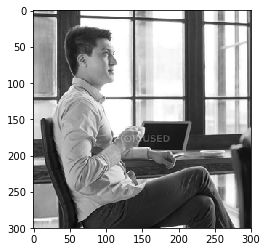

In [251]:
#Load training data

train_data = load_data("downloads/train")
print("Number of training images: ", len(train_data))
plt.imshow(train_data[13][0], cmap = 'gist_gray')  

Number of testing images:  141


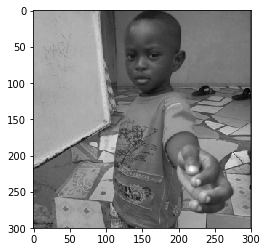

In [252]:
#Load testing Data

test_data = load_data('downloads/test')
print("Number of testing images: ", len(test_data))
plt.imshow(test_data[13][0], cmap = 'gist_gray')  

In [253]:
#Reshapes image to fit given dimensions
def reshape(img):
    return img.reshape(IMG_SIZE, IMG_SIZE, 1)

##Vectorizes data and turn lists into arrays
def vectorize_data_set(data_set, index=0, edit=False):
    output = []
    for element in data_set:
        item = element[index]
        if edit:
            item = reshape(item)
        output.append(item)
    return np.array(output)

In [254]:
#Vectorize training and testing data

trainImages = vectorize_data_set(train_data, 0, True)
trainLabels = vectorize_data_set(train_data, 1, False)

testImages = vectorize_data_set(test_data, 0, True)
testLabels = vectorize_data_set(test_data, 1, False)

In [256]:
import keras
from keras import models
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers. normalization import BatchNormalization

#The Keras model

model = models.Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 149, 149, 32)      128       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 73, 73, 64)        256       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 71, 71, 96)        55392     
__________

In [257]:
from keras_tqdm import TQDMNotebookCallback

#Train the model

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.fit(trainImages, trainLabels, batch_size = 50, epochs = 5, verbose = 0, callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)])

In [258]:
#Accuracy of test data on the model

test_loss, test_acc = model.evaluate(testImages, testLabels)
print(test_acc)

141/141 [==============================] - 73s 520ms/step
0.6453900734583536


In [266]:
#Use model to predict ethnicity of image

def evaluate_img(model, img):
    result = vectorize_data_set([img], 0, True)
    result = model.predict(result, verbose=0)
    if result[0][0] > 0.5:
        print("Guess: Chinese with", result[0][0]*100,"% confidence.")
    else:
        print("Guess: Ghanaian with", (1- result[0][0]) * 100 ,"% confidence.")
    plt.imshow(img[0], cmap = 'gist_gray')
    

Guess: Chinese with 99.88056421279907 % confidence.


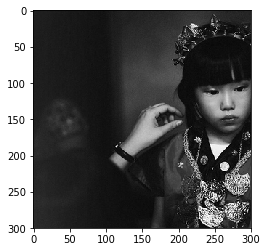

In [271]:
#Predict!

index = 38

evaluate_img(model, test_data[index])